## Introduction

Zillow's Economic Research Team collects, cleans and publishes housing and economic data from a variety of public and proprietary sources.
The datasets contain home value, market rate rent, as ratio of the housing stock and the share of all sales across a given region and housing type.
Our goal is to find the correlation between varies variables and predict the home values at county level.

We merged the Zillow dataset with various ones that help us to explain house prices (average personal income, employment etc..)

## Set Up - Import modules

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import json
import plotly.express as px
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Import the datasets

In [2]:
states_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/gz_2010_us_040_00_20m.json'
zillow_states = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/State_time_series.csv'
counties_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/gz_2010_us_050_00_20m.json'
path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/County_time_series.csv'
countyPop_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/county_populations_2000_to_2019.csv'
countyTs_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/County_time_series.csv'
countyEmployment_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/County employment/county_employment_ts.xlsx'
schools = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/Extra data/Public_Schools.csv'
hospitals = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/Extra data/Hospitals.csv'
mortgage = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/Extra data/Mortgage.csv'
crime_rate_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/Extra data/crime_data_w_population_and_crime_rate.csv'
hospital_ratings_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/Extra data/Hospital General Information.csv'
county_income_path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/CAINC1/CAINC1__ALL_AREAS_1969_2020.csv'
county_income_df = pd.read_csv(county_income_path, encoding='cp1252')
hospital_ratings_df = pd.read_csv(hospital_ratings_path, encoding='cp1252')
crime_rate_df = pd.read_csv(crime_rate_path)
mortgage_df = pd.read_csv(mortgage)
hospitals_df = pd.read_csv(hospitals)
schools_df = pd.read_csv(schools)
county_employment_df = pd.read_excel(countyEmployment_path)
countyTs_df = pd.read_csv(countyTs_path)
countyPop_df = pd.read_csv(countyPop_path)


## Data prep - Data Wrangling

In [3]:
county_employment_df = county_employment_df.drop(['state FIPS', 'county FIPS'], axis = 1)
county_employment_df = county_employment_df.rename(columns = {'Year':'year', 'FIPS': 'county_FIPS', 'county': 'county_name'})

countyTs_df['county_FIPS'] = countyTs_df['RegionName'] #Zillow data 
countyTs_df = countyTs_df.drop('RegionName', axis = 1)

countyPop_df = countyPop_df.melt(id_vars=['state_name', 'county_name', 'county_FIPS'], 
        var_name="year", 
        value_name="population")
countyPop_df['year'] = countyPop_df['year'].astype('int')

county_df = countyPop_df.merge(county_employment_df)

x = schools_df['COUNTYFIPS'].value_counts().to_frame()
x.reset_index(level= 0, inplace=True)
x = x.rename(index = str, columns={'index': 'county_FIPS', 'COUNTYFIPS': 'n_schools'})
schools_df = x

county_df = county_df.merge(schools_df)

x = hospitals_df['COUNTYFIPS'].value_counts().to_frame()
x.reset_index(level=0, inplace=True)
x = x.rename(index = str, columns={'index': 'county_FIPS', 'COUNTYFIPS': 'n_hospitals'})
x = x[x['county_FIPS']!= 'NOT AVAILABLE']
x['county_FIPS'] = x['county_FIPS'].astype('int')

county_df = county_df.merge(x)

hospital_ratings_df = hospital_ratings_df[['Provider ID', 'Hospital Name','Hospital overall rating']] # New, we cannot merge immediatly with hospitals because we want the total count
hospital_ratings_df = hospital_ratings_df[hospital_ratings_df['Hospital overall rating']!= 'Not Available']
col_n = {'Provider ID': 'ID', 'Hospital Name': 'NAME'}
hospital_ratings_df = hospital_ratings_df.rename(columns = col_n)

hospitals_df = hospitals_df.merge(hospital_ratings_df, on='NAME')
hospitals_df = hospitals_df[['COUNTYFIPS','Hospital overall rating']]
hospitals_df.groupby('COUNTYFIPS').median().reset_index()
hospitals_df = hospitals_df[hospitals_df['COUNTYFIPS']!= 'NOT AVAILABLE']
hospitals_df = hospitals_df.rename(columns={'COUNTYFIPS': 'county_FIPS', 'Hospital overall rating': 'avg_hospital_rating'})
hospitals_df = hospitals_df.dropna()
hospitals_df['county_FIPS'] = hospitals_df['county_FIPS'].astype('int')

county_df = county_df.merge(hospitals_df)

mortgage_df['year'] = pd.DatetimeIndex(mortgage_df['Date']).year
avg_mortgage_rate = mortgage_df.groupby('year').mean()
avg_mortgage_rate.reset_index(inplace=True)
avg_mortgage_rate = avg_mortgage_rate.rename(columns={'Mortgage': 'avg_mortgage_rate'})

county_df = county_df.merge(avg_mortgage_rate)

temp = countyTs_df[['Date','ZHVI_AllHomes','county_FIPS']]
countyTs_df = temp
countyTs_df['year'] = pd.DatetimeIndex(countyTs_df['Date']).year

county_df = county_df.merge(countyTs_df)
county_df = county_df.drop('state', axis = 1)

crime_rate_df['county_FIPS'] = crime_rate_df['FIPS_ST'].astype('str') + crime_rate_df['FIPS_CTY'].astype('str') # New
crime_rate_df['county_FIPS'] = crime_rate_df['county_FIPS'].astype('int')

crime_rate_df = crime_rate_df.groupby('county_FIPS').median().reset_index()
crime_rate_df = crime_rate_df[['county_FIPS', 'crime_rate_per_100000']]

county_df = county_df.merge(crime_rate_df)

county_income_df = county_income_df.loc[county_income_df['LineCode'] == 3.0] 
county_income_df['GeoFIPS'] = county_income_df['GeoFIPS'].str.replace(r'\D', '').astype(int)

county_income_df = county_income_df.melt(id_vars=['GeoFIPS', 'GeoName', 'Region', 'TableName', 'LineCode',
       'IndustryClassification', 'Description', 'Unit'], 
        var_name="year", 
        value_name="avg_personal_income")
county_income_df = county_income_df[['GeoFIPS', 'year', 'avg_personal_income']]
county_income_df = county_income_df.rename(columns={'GeoFIPS': 'county_FIPS'})
county_income_df = county_income_df.replace('(NA)', np.nan)
county_income_df = county_income_df.dropna()
county_income_df = county_income_df.astype({'county_FIPS': int,'year': int, 'avg_personal_income': int})


county_df = county_df.merge(county_income_df)

col_name = {'labor force': 'labor_force', 'unemployment rate ': 'unemployment_rate'}
county_df = county_df.rename(columns = col_name)

column_ind = ['state_name', 'county_name', 'county_FIPS', 'year', 'population',
       'labor_force', 'employed', 'unemployed', 'unemployment_rate',
       'n_schools', 'n_hospitals', 'avg_hospital_rating', 'crime_rate_per_100000', 'avg_personal_income','avg_mortgage_rate',
       'Date', 'ZHVI_AllHomes']

county_df = county_df.reindex(columns=column_ind) 

county_df['labor_force'] = county_df['labor_force'].astype('str')
county_df['employed'] = county_df['employed'].astype('str')
county_df['unemployed'] = county_df['unemployed'].astype('str')
county_df['unemployment_rate'] = county_df['unemployment_rate'].astype('str')


county_df = county_df.replace(['N.A.'], np.nan)

county_df = county_df.drop(['population',
       'labor_force', 'unemployed' ], axis=1)



/var/folders/y9/rwmb_3wj5xv2hq3_5m0543c80000gp/T/ipykernel_54851/2814449573.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  county_income_df['GeoFIPS'] = county_income_df['GeoFIPS'].str.replace(r'\D', '').astype(int)


## Two possible approaches:
##### 1) Drop NaN values and reduce the size of the dataset by a lot
##### 2) Compute the median/mean of the columns with NaN values and fill them with the result

In [4]:
county_df_1 = county_df.copy()
county_df_1 = county_df_1.dropna()

In [5]:
county_df_2 = county_df.copy()
county_df_2.isna().sum()

state_name                   0
county_name                  0
county_FIPS                  0
year                         0
employed                     0
unemployment_rate            0
n_schools                    0
n_hospitals                  0
avg_hospital_rating          0
crime_rate_per_100000        0
avg_personal_income          0
avg_mortgage_rate            0
Date                         0
ZHVI_AllHomes            42713
dtype: int64

In [6]:
# Use median for all the columns with NaN except MedianListingPricePerSqft_AllHomes since outliers have already been removed
county_df_2['ZHVI_AllHomes'].fillna(value = county_df_2['ZHVI_AllHomes'].median(), inplace = True)

In [7]:
d_types = {'state_name':str, 'county_name':str, 'county_FIPS':int,'Date':'datetime64[ns]','year':int, 'employed':int, 'unemployment_rate':float,
       'n_schools':int, 'n_hospitals':int, 'avg_hospital_rating': int ,'avg_mortgage_rate':float,
        'ZHVI_AllHomes':int}

county_df_2 = county_df_2.astype(d_types)

In [8]:
county_df_2.isna().sum()

state_name               0
county_name              0
county_FIPS              0
year                     0
employed                 0
unemployment_rate        0
n_schools                0
n_hospitals              0
avg_hospital_rating      0
crime_rate_per_100000    0
avg_personal_income      0
avg_mortgage_rate        0
Date                     0
ZHVI_AllHomes            0
dtype: int64

## Exploratory Data Analysis

In [9]:
county_df_2.head()

state_name        county_name  county_FIPS  year  employed  \
0    Alabama  Montgomery County         1101  2000    101919   
1    Alabama  Montgomery County         1101  2000    101919   
2    Alabama  Montgomery County         1101  2000    101919   
3    Alabama  Montgomery County         1101  2000    101919   
4    Alabama  Montgomery County         1101  2000    101919   

   unemployment_rate  n_schools  n_hospitals  avg_hospital_rating  \
0                4.2         76            8                    3   
1                4.2         76            8                    3   
2                4.2         76            8                    3   
3                4.2         76            8                    3   
4                4.2         76            8                    3   

   crime_rate_per_100000  avg_personal_income  avg_mortgage_rate       Date  \
0             396.631062                28390           8.053462 2000-01-31   
1             396.631062                28390           8.053462 2000-02-29   
2             396.631062                28390           8.053462 2000-03-31   
3             396.631062                28390           8.053462 2000-04-30   
4             396.631062                28390           8.053462 2000-05-31   

   ZHVI_AllHomes  
0         115700  
1         115700  
2         115700  
3         115700  
4         115700

In [10]:
county_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181955 entries, 0 to 181954
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   state_name             181955 non-null  object        
 1   county_name            181955 non-null  object        
 2   county_FIPS            181955 non-null  int64         
 3   year                   181955 non-null  int64         
 4   employed               181955 non-null  int64         
 5   unemployment_rate      181955 non-null  float64       
 6   n_schools              181955 non-null  int64         
 7   n_hospitals            181955 non-null  int64         
 8   avg_hospital_rating    181955 non-null  int64         
 9   crime_rate_per_100000  181955 non-null  float64       
 10  avg_personal_income    181955 non-null  int64         
 11  avg_mortgage_rate      181955 non-null  float64       
 12  Date                   181955 non-null  date

In [11]:
county_df_2.describe()

county_FIPS           year      employed  unemployment_rate  \
count  181955.000000  181955.000000  1.819550e+05      181955.000000   
mean    28710.941975    2009.113940  1.957979e+05           6.222921   
std     14884.370311       5.187169  3.906863e+05           2.454200   
min      1101.000000    2000.000000  1.917000e+03           1.100000   
25%     17135.000000    2005.000000  1.630700e+04           4.500000   
50%     27123.000000    2010.000000  5.271000e+04           5.700000   
75%     42125.000000    2014.000000  1.589130e+05           7.500000   
max     55141.000000    2017.000000  2.149903e+06          25.600000   

           n_schools    n_hospitals  avg_hospital_rating  \
count  181955.000000  181955.000000        181955.000000   
mean      129.844868       9.488571             3.120167   
std       253.242286      17.523953             0.802528   
min         3.000000       1.000000             1.000000   
25%        16.000000       1.000000             3.000000   
50%        39.000000       3.000000             3.000000   
75%       103.000000       8.000000             4.000000   
max      1246.000000      93.000000             5.000000   

       crime_rate_per_100000  avg_personal_income  avg_mortgage_rate  \
count          181955.000000        181955.000000      181955.000000   
mean              338.140394         35984.759199           5.147520   
std               228.575751         10010.783496           1.261172   
min                 0.000000         10293.000000           3.654038   
25%               169.680305         29310.000000           3.975577   
50%               282.287456         34423.000000           4.689808   
75%               449.777629         40590.000000           6.027170   
max              1315.003752        123333.000000           8.053462   

       ZHVI_AllHomes  
count  181955.000000  
mean   129426.927537  
std     61038.041558  
min     35100.000000  
25%    100800.000000  
50%    115700.000000  
75%    137500.000000  
max    633100.000000

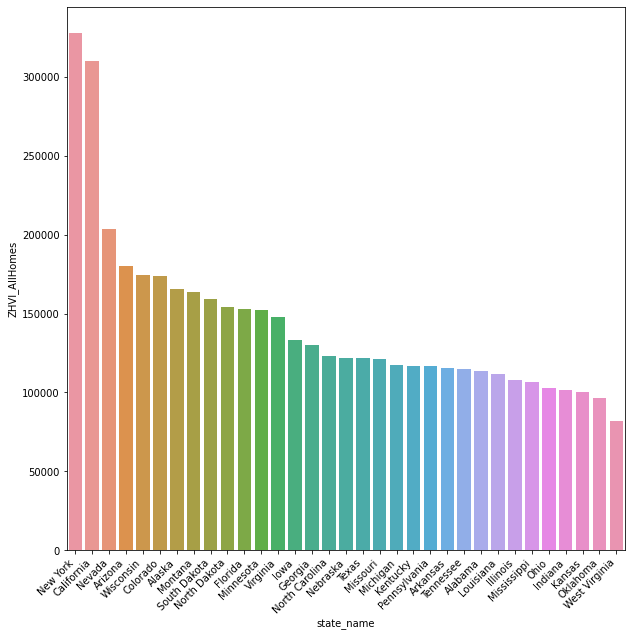

In [12]:
plot_data = county_df_2.groupby('state_name').mean().reset_index()
figure(figsize = (10,10))
plot = sns.barplot(data = plot_data, x = 'state_name', y = 'ZHVI_AllHomes', order= plot_data.sort_values('ZHVI_AllHomes', ascending= False).state_name)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show();

In [13]:
#Prepare dataset and plot average house price by state between 2000 and 2017
us_states = json.load(open(states_path, 'r'))
states_plot = pd.read_csv(zillow_states)

def modify_names(df, column_name, words_to_replace_dict):
    for key, values in words_to_replace_dict.items():
        df.loc[df[column_name].str.contains(key), column_name] = values

replace = {'DistrictofColumbia': 'District of Columbia', 'NewHampshire': 'New Hampshire',
            'NewJersey': 'New Jersey', 'NewMexico':'New Mexico','NewYork': 'New York',
            'NorthCarolina': 'North Carolina', 'NorthDakota':'North Dakota',
            'RhodeIsland': 'Rhode Island', 'SouthCarolina': 'South Carolina',
            'SouthDakota': 'South Dakota', 'WestVirginia': 'West Virginia'}

states_plot = states_plot[states_plot["RegionName"].str.contains("UnitedStates")==False]

modify_names(states_plot, 'RegionName', replace)

states_plot = states_plot[states_plot['Date'] > '2000-01-01']
states_plot['ZHVI_AllHomes'] = states_plot['ZHVI_AllHomes'].fillna(states_plot['ZHVI_AllHomes'].median())

states_plot = states_plot.groupby('RegionName').mean().reset_index()

state_id_map = {}
for feature in us_states['features']:
    feature['id'] = feature['properties']['STATE']
    state_id_map[feature['properties']['NAME']] = feature['id']

states_plot['id'] = states_plot['RegionName'].apply(lambda x: state_id_map[x])

fig = px.choropleth(states_plot, locations='id', geojson=us_states, color='ZHVI_AllHomes', scope='usa', labels={'ZHVI_AllHomes':'Average house price between 2000 and 2017'})
fig.show()


In [14]:
path = '/Users/gioel/Desktop/BBS/Machine Learning/Project/archive/County_time_series.csv'
us_counties = json.load(open(counties_path, 'r', encoding='cp1252'))
for feature in us_counties['features']:
    feature['id'] = feature['properties']['STATE']+feature['properties']['COUNTY']

counties_plot = pd.read_csv(path)

counties_plot = counties_plot[counties_plot['Date'] > '2000-01-01']

counties_plot['ZHVI_AllHomes'] = counties_plot['ZHVI_AllHomes'].fillna(counties_plot['ZHVI_AllHomes'].median())
counties_plot = counties_plot.groupby('RegionName').mean().reset_index()
counties_plot['data'] = counties_plot['RegionName'].astype(str)
counties_plot['data'] = counties_plot['data'].str.pad(5, 'left', '0')

target_states = ['06']
us_counties['features'] = [f for f in us_counties['features'] if f['properties']['STATE'] in target_states]

fig = px.choropleth(counties_plot, locations='data', geojson=us_counties, color='ZHVI_AllHomes', scope='usa', labels={'ZHVI_AllHomes':'Average house price in California between 2000 and 2017'})
fig.show()

In [15]:
us_counties = json.load(open(counties_path, 'r', encoding='cp1252'))
for feature in us_counties['features']:
    feature['id'] = feature['properties']['STATE']+feature['properties']['COUNTY']

target_states = ['36']
us_counties['features'] = [f for f in us_counties['features'] if f['properties']['STATE'] in target_states]

fig = px.choropleth(counties_plot, locations='data', geojson=us_counties, color='ZHVI_AllHomes', scope='usa', labels={'ZHVI_AllHomes':'Average house price in New York between 2000 and 2017'})
fig.show()

In [16]:
county_df_2.corr()

county_FIPS      year  employed  unemployment_rate  \
county_FIPS               1.000000 -0.006120 -0.039867          -0.123486   
year                     -0.006120  1.000000 -0.029237           0.136423   
employed                 -0.039867 -0.029237  1.000000          -0.062059   
unemployment_rate        -0.123486  0.136423 -0.062059           1.000000   
n_schools                -0.054743 -0.051329  0.985939          -0.040396   
n_hospitals               0.021418 -0.048606  0.970201          -0.063473   
avg_hospital_rating       0.036375  0.004288 -0.064026          -0.085243   
crime_rate_per_100000    -0.106944 -0.045318  0.368760           0.115340   
avg_personal_income       0.059059  0.509628  0.283867          -0.184886   
avg_mortgage_rate         0.005180 -0.928120  0.033272          -0.267660   
ZHVI_AllHomes            -0.095884  0.054538  0.251440          -0.192922   

                       n_schools  n_hospitals  avg_hospital_rating  \
county_FIPS            -0.054743     0.021418             0.036375   
year                   -0.051329    -0.048606             0.004288   
employed                0.985939     0.970201            -0.064026   
unemployment_rate      -0.040396    -0.063473            -0.085243   
n_schools               1.000000     0.965175            -0.065311   
n_hospitals             0.965175     1.000000            -0.037290   
avg_hospital_rating    -0.065311    -0.037290             1.000000   
crime_rate_per_100000   0.378472     0.387325            -0.171435   
avg_personal_income     0.216391     0.247821             0.004558   
avg_mortgage_rate       0.051182     0.048449            -0.004311   
ZHVI_AllHomes           0.210228     0.161358            -0.050024   

                       crime_rate_per_100000  avg_personal_income  \
county_FIPS                        -0.106944             0.059059   
year                               -0.045318             0.509628   
employed                            0.368760             0.283867   
unemployment_rate                   0.115340            -0.184886   
n_schools                           0.378472             0.216391   
n_hospitals                         0.387325             0.247821   
avg_hospital_rating                -0.171435             0.004558   
crime_rate_per_100000               1.000000             0.076799   
avg_personal_income                 0.076799             1.000000   
avg_mortgage_rate                   0.045098            -0.459507   
ZHVI_AllHomes                      -0.109015             0.544099   

                       avg_mortgage_rate  ZHVI_AllHomes  
county_FIPS                     0.005180      -0.095884  
year                           -0.928120       0.054538  
employed                        0.033272       0.251440  
unemployment_rate              -0.267660      -0.192922  
n_schools                       0.051182       0.210228  
n_hospitals                     0.048449       0.161358  
avg_hospital_rating            -0.004311      -0.050024  
crime_rate_per_100000           0.045098      -0.109015  
avg_personal_income            -0.459507       0.544099  
avg_mortgage_rate               1.000000      -0.020970  
ZHVI_AllHomes                  -0.020970       1.000000

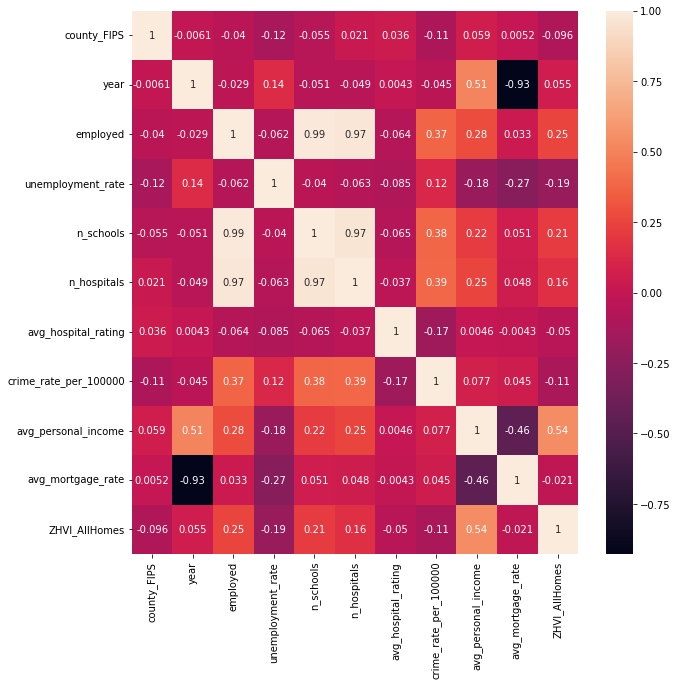

In [17]:
figure(figsize = (10,10))
sns.heatmap(county_df_2.corr(), annot= True);

<Figure size 720x720 with 0 Axes>

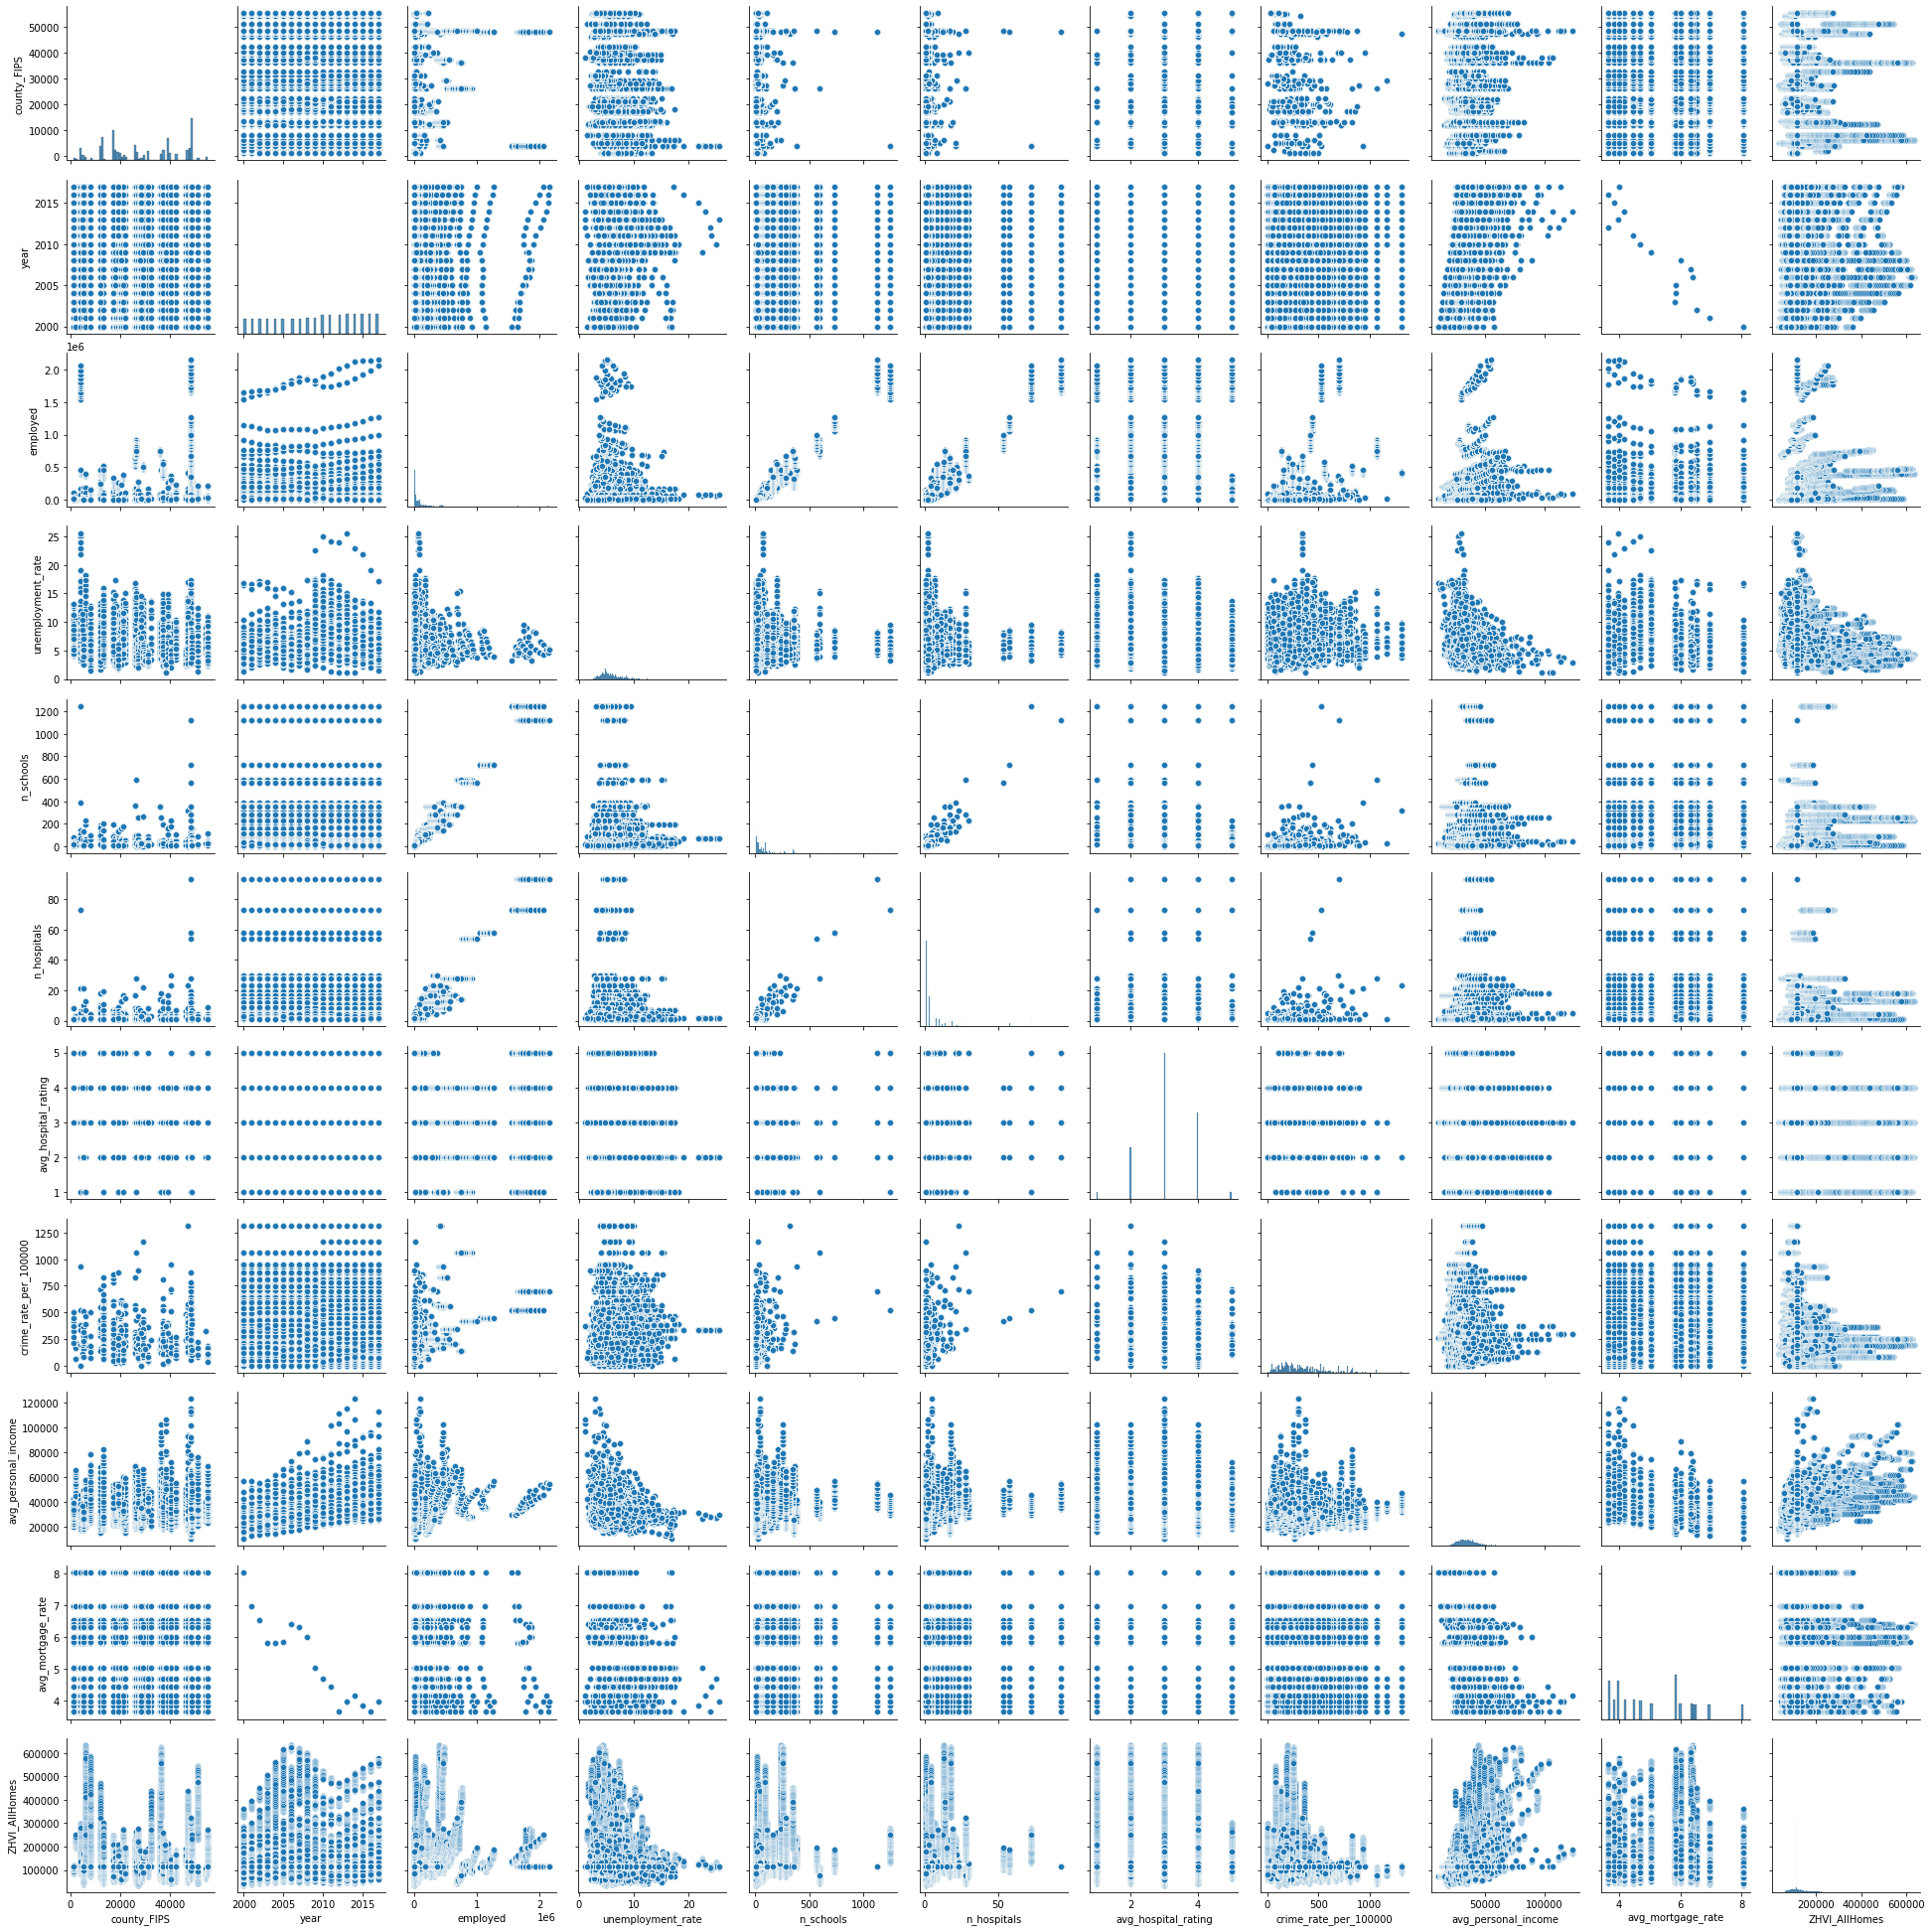

In [18]:
figure(figsize = (10,10))
sns.pairplot(county_df_2)

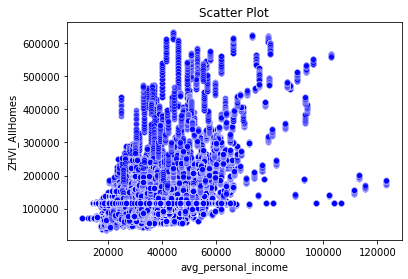

In [19]:
#positive correlation
sns.scatterplot(data=county_df_2, x='avg_personal_income', y='ZHVI_AllHomes', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

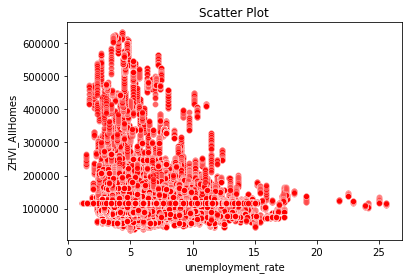

In [20]:
#negative correlation
sns.scatterplot(data=county_df_2, x='unemployment_rate', y='ZHVI_AllHomes', markers='o', color='red', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

<AxesSubplot:xlabel='ZHVI_AllHomes', ylabel='state_name'>

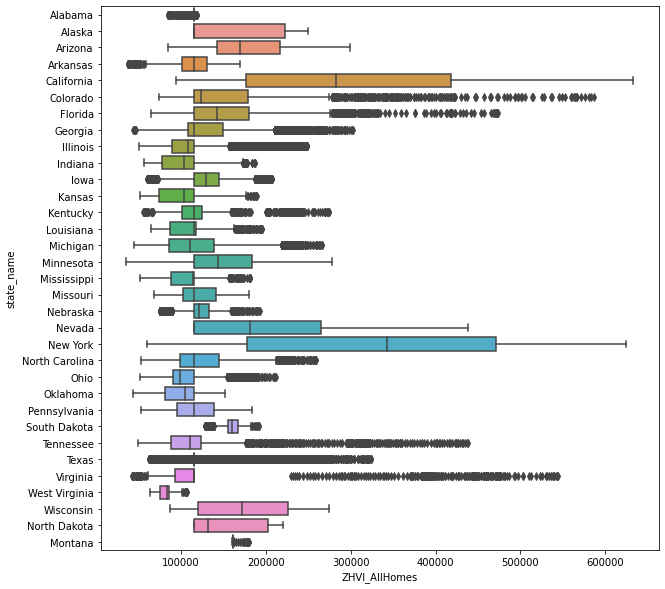

In [21]:
figure(figsize = (10, 10))
sns.boxplot(x='ZHVI_AllHomes', y='state_name', data=county_df_2)


## Modeling

In [22]:
county_df_2 = county_df_2.drop(['state_name', 'county_name', 'county_FIPS', 'Date'], axis = 1).copy()

X = county_df_2.drop(['ZHVI_AllHomes'], axis = 1)
y = county_df_2['ZHVI_AllHomes']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= 50)


In [23]:
Xtrain.shape, ytrain.shape

((136466, 9), (136466,))

In [24]:
Xtest.shape, ytest.shape

((45489, 9), (45489,))

In [25]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['features'] = Xtrain.columns
vif["VIF Factor"] = [variance_inflation_factor(Xtrain.values, i) for i in range(Xtrain.shape[1])]
vif.round(1)



features  VIF Factor
0                   year       123.9
1               employed        67.7
2      unemployment_rate         9.5
3              n_schools        56.6
4            n_hospitals        24.0
5    avg_hospital_rating        16.9
6  crime_rate_per_100000         4.0
7    avg_personal_income        26.7
8      avg_mortgage_rate        27.4

In [26]:
def correlation(dataset, threshold): 
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

In [27]:
corr_features = correlation(Xtrain, 0.8)
corr_features

{'n_hospitals', 'n_schools'}

In [28]:
Xtrain.drop(corr_features, axis = 1)
Xtest.drop(corr_features, axis = 1)

year  employed  unemployment_rate  avg_hospital_rating  \
55628   2013     28869                6.2                    4   
136777  2014   2114484                5.1                    4   
133914  2004     16279                6.0                    3   
12481   2007     92108                5.7                    4   
132396  2013      8522                4.2                    2   
...      ...       ...                ...                  ...   
34857   2006     18085                4.1                    4   
57607   2003    106894                4.8                    2   
32824   2008     10429                6.3                    3   
22471   2000     48201                2.6                    2   
171635  2011     12723               10.6                    4   

        crime_rate_per_100000  avg_personal_income  avg_mortgage_rate  
55628              265.360612                46499           3.975577  
136777             696.103834                55255           4.168868  
133914             212.504194                23013           5.839231  
12481              271.759053                38755           6.337308  
132396             110.987791                42001           3.975577  
...                       ...                  ...                ...  
34857              227.832190                30936           6.413269  
57607              197.120924                32995           5.826981  
32824               83.464713                29716           6.027170  
22471               78.438610                37635           8.053462  
171635             276.175494                33052           4.447885  

[45489 rows x 7 columns]

## Estimator tests

In [29]:
from sklearn.linear_model import LinearRegression 
from sklearn import metrics

model = LinearRegression()
model.fit(Xtrain, ytrain)

pred = model.predict(Xtest)


print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, pred)))

Mean Absolute Error: 28799.882443960818
Mean Squared Error: 1921903181.3572607
Root Mean Squared Error: 43839.51620806576


In [30]:
ytrain.mean()

129521.35916638577

In [31]:
# fit regression model in training set
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(Xtrain, ytrain)

# predict in test set
pred_test = lr.predict(Xtest)


In [32]:
# coefficients
print(lr.coef_)

[-2.09811168e+03  1.27345937e-01  2.89537564e+02  9.70458259e+01
 -3.91772137e+03 -3.66120223e+03 -5.44871804e+01  4.14883785e+00
  7.02520626e+03]


In [33]:
# compare between Actual and Predition
df_new = pd.DataFrame({'Actual': ytest, 'Prediction': pred_test})
df_new = df_new.sort_values(by='Actual').reset_index(drop=True)

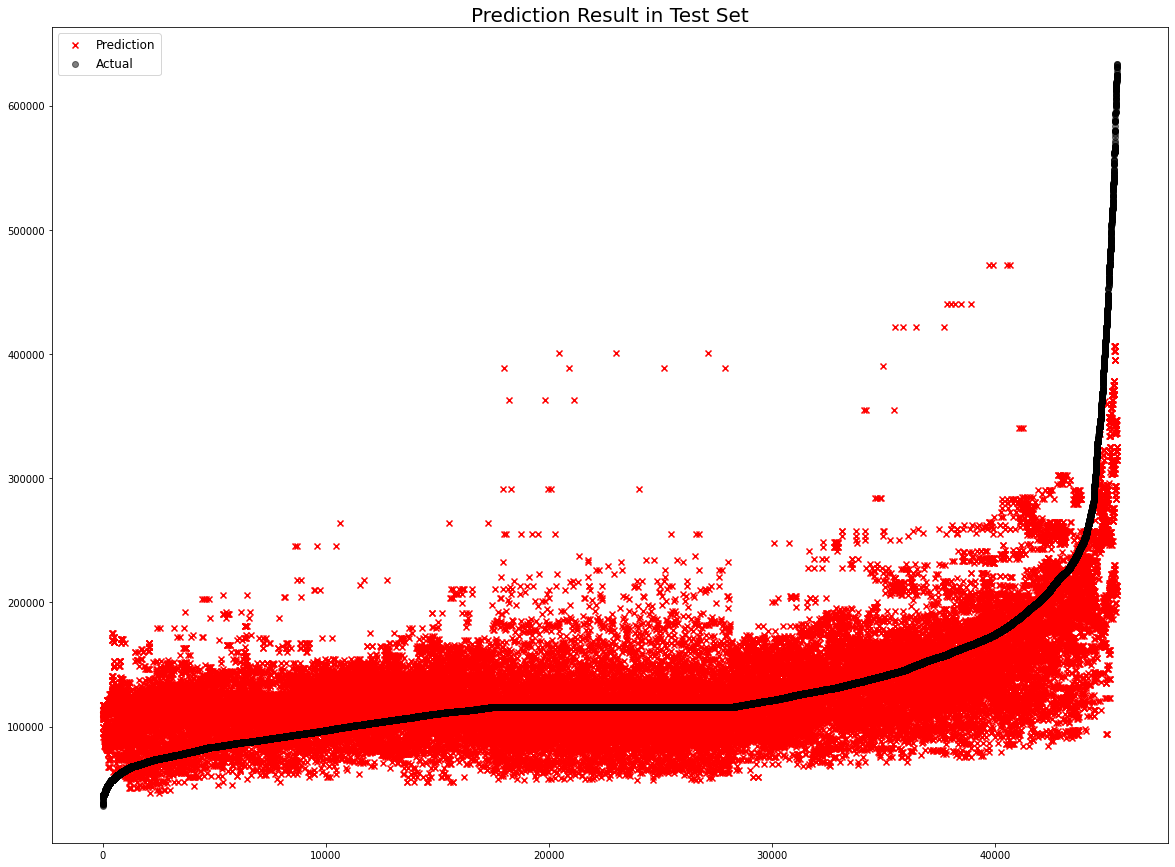

In [34]:
# compare between Actual and Predition
plt.figure(figsize=(20, 15))
plt.scatter(df_new.index, df_new['Prediction'], marker='x', color='red')
plt.scatter(df_new.index, df_new['Actual'], alpha=0.5, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['Prediction', 'Actual'], fontsize=12)
plt.show()


In [35]:
# linear regression analysis
import statsmodels.api as sm 

Xtrain2 = sm.add_constant(Xtrain)
model2 = sm.OLS(ytrain, Xtrain2).fit()
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZHVI_AllHomes   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 1.453e+04
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:55:12   Log-Likelihood:            -1.6517e+06
No. Observations:              136466   AIC:                         3.303e+06
Df Residuals:                  136456   BIC:                         3.303e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.187e+06   1.33e+05     31.505      0.000    3.93e+06    4.45e+06
year                  -2098.1117     65.513    -32.026      0.000   -2226.516   -1969.707
employed                  0.1273      0.002     57.350      0.000       0.123       0.132
unemployment_rate       289.5376     56.351      5.138      0.000     179.091     399.984
n_schools                97.0458      3.118     31.129      0.000      90.935     103.156
n_hospitals           -3917.7214     29.019   -135.005      0.000   -3974.598   -3860.844
avg_hospital_rating   -3661.2022    150.935    -24.257      0.000   -3957.032   -3365.372
crime_rate_per_100000   -54.4872      0.579    -94.146      0.000     -55.622     -53.353
avg_personal_income       4.1488      0.017    251.109      0.000       4.116       4.181
avg_mortgage_rate      7025.2063    274.442     25.598      0.000    6487.306    7563.107
==============================================================================
Omnibus:                    73488.265   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1269420.351
Skew:                           2.212   Prob(JB):                         0.00
Kurtosis:                      17.271   Cond. No.                     4.93e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# R square
print(model.score(Xtrain, ytrain))  # training set
print(model.score(Xtest, ytest))


0.48928765069652325
0.4815917841521905


# Compare estimators 

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)

y_pred_lr = lin_reg.predict(Xtest)
rms_lr = np.sqrt(mean_squared_error(ytest, y_pred_lr))
print(rms_lr)

43839.51620806576


In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(Xtrain, ytrain)

y_pred_dtr = tree_reg.predict(Xtest)
rms_dtr = np.sqrt(mean_squared_error(ytest, y_pred_dtr))
print(rms_dtr)

4124.304706298297


In [39]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(Xtrain, ytrain)

y_pred_rfr = forest_reg.predict(Xtest)
rms_rfr = np.sqrt(mean_squared_error(ytest, y_pred_rfr))
print(rms_rfr)

4125.966856122786


In [40]:
gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(Xtrain, ytrain)

y_pred_gbr = gbr_reg.predict(Xtest)
rms_gbr = np.sqrt(mean_squared_error(ytest, y_pred_gbr))
print(rms_gbr)

25676.441988783212


In [41]:
hyperparams = {'n_estimators': [100, 150], 
                'learning_rate': [0.05,0.1, 0.15, 0.20],
                'max_depth': [10,11,12]}

reg = GridSearchCV(estimator= GradientBoostingRegressor(),
                param_grid=hyperparams,
                scoring='r2')

reg.fit(Xtrain, ytrain.values.ravel())
reg.best_params_, reg.best_score_

({'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 150},
 0.9957107163754528)

# Best Estimator

In [45]:
gbr_reg = GradientBoostingRegressor(
     n_estimators=150, learning_rate=0.2, max_depth=12, random_state=0,
     loss='squared_error').fit(Xtrain, ytrain.values.ravel())

pred_best_gbr = gbr_reg.predict(Xtest)
rms_best_gbr = np.sqrt(mean_squared_error(ytest, pred_best_gbr))
print(rms_best_gbr)

4118.439833246165


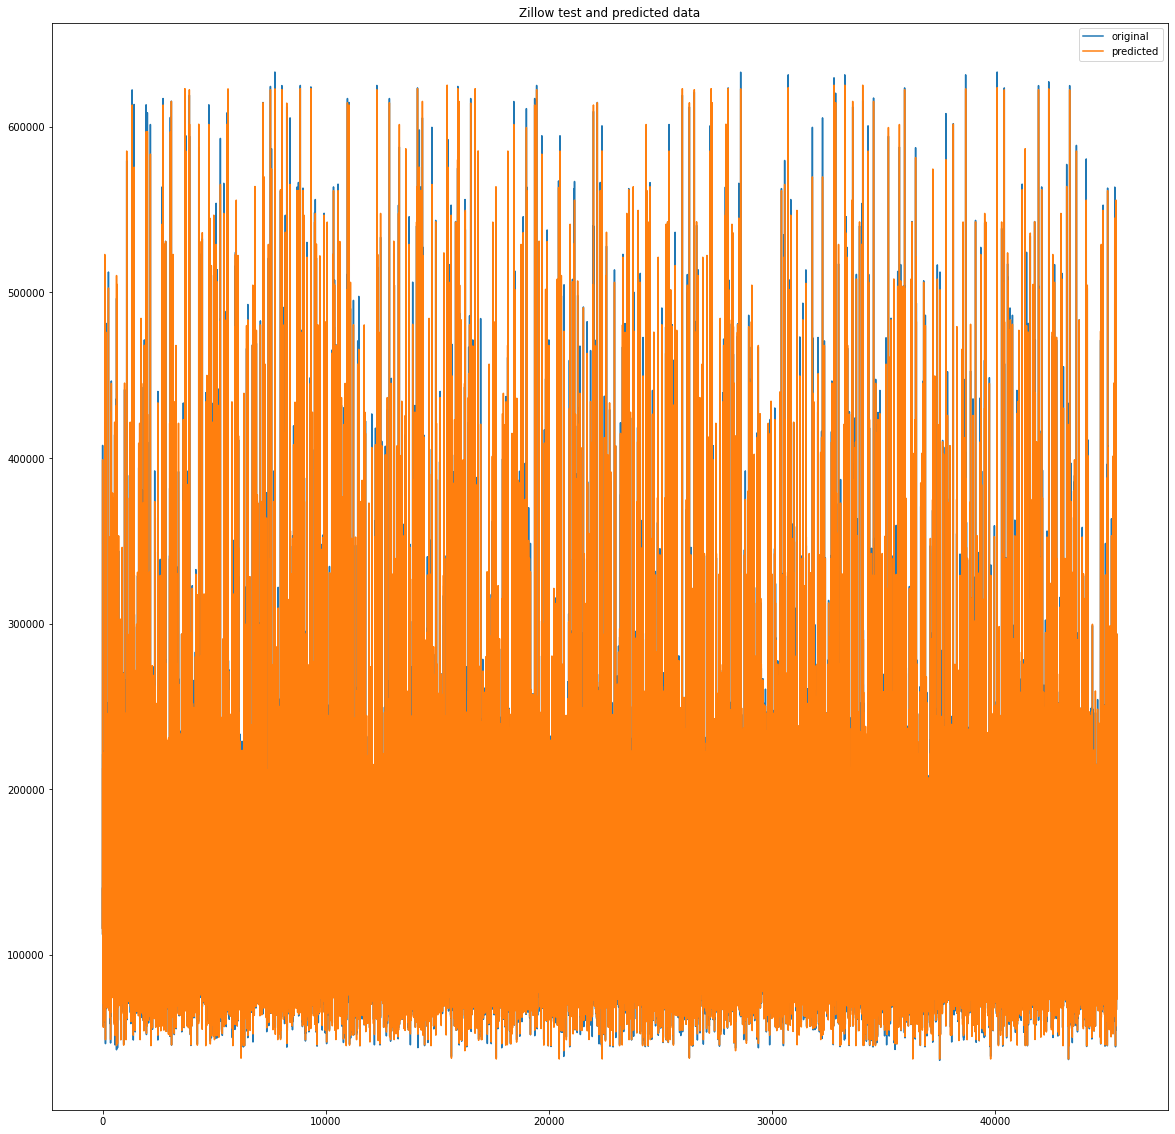

In [46]:
figure(figsize = (20,20))
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, pred_best_gbr, label="predicted")
plt.title("Zillow test and predicted data")
plt.legend()
plt.show()

# Conclusion

In [47]:
results = {'Linear regression': rms_lr, 'Decision tree regressor': rms_dtr,
            'Random forest regressor': rms_rfr, 'Gradient boosting regressor': rms_best_gbr }
results_df = pd.DataFrame(results.items(), columns=['Model', 'Rmse'])

results_df

Model          Rmse
0            Linear regression  43839.516208
1      Decision tree regressor   4124.304706
2      Random forest regressor   4125.966856
3  Gradient boosting regressor   4118.439833

As we can notice from the results, gradient boosting regressor performs slightly better than the others once tuning is conducted. 

From the correlation matrix, we can clearly notice that house prices are positively correlated with personal income and the number of employed people while it is negatively correlated with unemployment rate (as expected). 

The main challenges of the project were related to data at county level. In fact, a lot of counties do not provide data about all the variables that we believe are necessary in order to make a full analysis at national level. In addition, data reconciliation is often difficult because of the different standards used by the sources of our data. 

In future, it would be interesting to analyse data at city level, since some counties have a strong difference in house prices that can be reconducted to the presence of different cities